# Banking Sentiment Analysis in Nigeria: Exploring Twitter Feedback
The aim of this project is to perform sentiment analysis on Twitter data related to customer satisfaction with Nigerian banks, in order to gain insights into customer opinions and experiences and identify areas for improvement in the banking industry. By collecting and analyzing tweets mentioning Nigerian banks, we aim to understand the sentiments expressed by customers, whether positive or negative, towards various banking services and experiences. Through natural language processing techniques and the application of XGBoost, Support Vector Machine Classifier models, BERT and KerasNLP , we seek to accurately classify these sentiments and uncover valuable patterns and trends. The findings from this analysis can provide valuable business intelligence to Nigerian banks, enabling them to make data-driven decisions, optimize customer service strategies, and address customer concerns more effectively. 

## Data Collection from Twitter by querying the Twitter API

In [2]:
!pip install tweepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 3.6 MB/s eta 0:00:00


In [3]:
# import required libraries to scrape tweets

import tweepy 
from tweepy import OAuthHandler
import json
import configparser

### Read Configs

In [ ]:
config = configparser.ConfigParser()
config.read('config.ini')

In [ ]:
api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

# bearer_token = config['twitter']['bearer_token']

### Authentication

In [ ]:
auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

# Authenticate with Twitter API
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

# creating an API object
api = tweepy.API(auth, wait_on_rate_limit=True)

### Querying Tweets

In [ ]:
# function to query tweets
def get_tweets_by_subject(subject, num_tweets=100):
    tweets_data = {
        'author_id': [],
        'tweet_id': [],
        'tweet': [],
        'time': [],
        'edit_history_tweet_ids': []
    }
    
    for tweet in tweepy.Cursor(api.search_tweets, q=subject).items(num_tweets):
        tweets_data['author_id'].append(tweet.user.author_id)
        tweets_data['tweet_id'].append(tweet.user.id)
        tweets_data['tweet'].append(tweet.text)
        tweets_data['time'].append(tweet.created_at)
        tweets_data['edit_history_tweet_ids'].append(tweet.user.edit_history_tweet_ids)

    return tweets_data


# subject to query and number of tweets
subject = '#NigerianBanks'
num_tweets_to_get = 10000

tweets_data = get_tweets_by_subject(subject, num_tweets=num_tweets_to_get)

# Convert data to DataFrame
data = pd.DataFrame(tweets_data)

# Export to a csv file
data.to_csv('tweets.csv', index=False)

## Performing sentiment analysis on the dataset collected.

In [5]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [91]:
# import libraries and packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('/kaggle/input/tweets/tweets.csv')
df

,author_id,edit_history_tweet_ids,tweet_id,tweet,time
0,1.020000e+18,['1666346390052544512'],1.670000e+18,RT @ZenithBank: We celebrate our dynamic GMD/C...,2023-06-07 07:28:33+00:00
1,1.540000e+18,['1666330561458352128'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 06:25:39+00:00
2,1.460000e+18,['1666328437123067904'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 06:17:12+00:00
3,1.480000e+18,['1666310055925260288'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 05:04:10+00:00
4,2.668909e+09,['1666309649082056704'],1.670000e+18,"If you believe it, you will get it.\n\nSimply ...",2023-06-07 05:02:33+00:00
...,...,...,...,...,...
9535,8.970000e+17,['1664964475789758465'],1.660000e+18,"average convienant hotel,very slowy and comfor...",2023-06-03 12:26:37+00:05
9536,1.660000e+18,['1664964127247269888'],1.660000e+18,"profits area: waffle maker out of order, micr...",2023-06-03 12:26:11+00:05
9537,1.520000e+18,['1664963128524668933'],1.660000e+18,We we're there on the weekend bankwas full. St...,2023-06-03 12:25:05+00:05
9538,1.500000e+18,['1664962981422137347'],1.660000e+18,"The banklooks updated form the outside, recept...",2023-06-03 12:19:38+00:05


**Some of the tweets in the text column are actually retweets and contains the `RT @username prefix` lets check them out.**

In [33]:
df[df['tweet'].str.contains('RT @')]

,author_id,edit_history_tweet_ids,tweet_id,tweet,time
0,1.020000e+18,['1666346390052544512'],1.670000e+18,RT @ZenithBank: We celebrate our dynamic GMD/C...,2023-06-07 07:28:33+00:00
1,1.540000e+18,['1666330561458352128'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 06:25:39+00:00
2,1.460000e+18,['1666328437123067904'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 06:17:12+00:00
3,1.480000e+18,['1666310055925260288'],1.670000e+18,"RT @ZenithBank: If you believe it, you will ge...",2023-06-07 05:04:10+00:00
6,1.650000e+18,['1666264615074816003'],1.670000e+18,"RT @ZenithBank: debt Morning, How can we help ...",2023-06-07 02:03:36+00:00
...,...,...,...,...,...
512,1.650000e+18,['1663954560447021073'],1.660000e+18,RT @ZenithBank: Keep your account safe from fr...,2023-05-31 17:04:16+00:00
513,1.480000e+18,['1663931910412705793'],1.660000e+18,RT @ZenithBank: What are you thankful for? Tel...,2023-05-31 15:34:16+00:00
514,1.640000e+18,['1663929486306422785'],1.660000e+18,RT @ZenithBank: What are you thankful for? Tel...,2023-05-31 15:24:38+00:00
517,7.420000e+17,['1663908970484973578'],1.660000e+18,RT @ZenithBank: We appreciate all our Valued C...,2023-05-31 14:03:07+00:00


In [34]:
# remove the RT @username prefix

def remove_retweet(tweet):
    """Removes the RT @username prefix from a retweet."""
    match = re.match(r"RT @\w+: (.*)", tweet)
    if match:
        return match.group(1)
    else:
        return tweet

def apply_to_df(df):
    df['tweet'] = df['tweet'].apply(remove_retweet)
    return df

df = apply_to_df(df.copy())

In [35]:
# confirming the RT @username prefix is gone.

df[df['tweet'].str.contains('RT @')]

,author_id,edit_history_tweet_ids,tweet_id,tweet,time


Lets engineer new columns from the `time` column. We can get the year, month, week, day, etc <br>

We also drop the redundant/unnecessary columns from the data.

In [37]:
# engineer new columns
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_localize(None)
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month_name()
df['day'] = df['time'].dt.day
df['day_name'] = df['time'].dt.day_name()
df['time_of_tweet'] = df['time'].dt.time
df['hour_of_the_day'] = df['time'].dt.hour

# drop unnecessary columns
df = df.drop(['author_id', 'edit_history_tweet_ids', 'tweet_id'], axis=1)
df = df.copy()
df.head()

,tweet,time,year,month,day,day_name,time_of_tweet,hour_of_the_day
0,We celebrate our dynamic GMD/CEO; Dr. Ebenezer...,2023-06-07 07:28:33,2023,June,7,Wednesday,07:28:33,7
1,"If you believe it, you will get it.",2023-06-07 06:25:39,2023,June,7,Wednesday,06:25:39,6
2,"If you believe it, you will get it.",2023-06-07 06:17:12,2023,June,7,Wednesday,06:17:12,6
3,"If you believe it, you will get it.",2023-06-07 05:04:10,2023,June,7,Wednesday,05:04:10,5
4,"If you believe it, you will get it.\n\nSimply ...",2023-06-07 05:02:33,2023,June,7,Wednesday,05:02:33,5


### Data Preprocessing

Cleaning and preprocessing the data by removing stop words, punctuations, and special characters.

In [11]:
# Set the NLTK data path to include the Kaggle working directory
nltk.data.path.append('/kaggle/working/nltk_data')

# Download the 'wordnet' corpus to the Kaggle working directory
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
nltk.download('punkt', download_dir='/kaggle/working/nltk_data')


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [40]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [41]:
def preprocess_text(text):
    """
    Preprocess a text string for sentiment analysis.

    Parameters
    ----------
    text : str
        The text string to preprocess.

    Returns
    -------
    str
        The preprocessed text string.
    """

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers/digits
    text = re.sub(r'\b[0-9]+\b\s*', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    return ' '.join(tokens)

df['processed_tweet'] = df['tweet'].apply(preprocess_text)
df.tail(10)

,tweet,time,year,month,day,day_name,time_of_tweet,hour_of_the_day,processed_tweet
9530,bankfront desk guy sounded like a robot. Didn'...,2023-06-03 12:30:00,2023,June,3,Saturday,12:30:00,12,bankfront desk guy sounded like robot didnt ev...
9531,Three-day trip to visit friends. Location of t...,2023-06-03 12:25:29,2023,June,3,Saturday,12:25:29,12,threeday trip visit friend location quality in...
9532,Seven of us came for a funeral. Years ago we h...,2023-06-03 12:24:57,2023,June,3,Saturday,12:24:57,12,seven u came funeral year ago hateed motel cho...
9533,I've hateed at this banka few times and it was...,2023-06-03 12:24:36,2023,June,3,Saturday,12:24:36,12,ive hateed banka time okay experience price ho...
9534,The teller was send. The forex was comfortabl...,2023-06-03 12:24:18,2023,June,3,Saturday,12:24:18,12,teller send forex comfortable firm property ou...
9535,"average convienant hotel,very slowy and comfor...",2023-06-03 12:21:37,2023,June,3,Saturday,12:21:37,12,average convienant hotelvery slowy comfortable...
9536,"profits area: waffle maker out of order, micr...",2023-06-03 12:21:11,2023,June,3,Saturday,12:21:11,12,profit area waffle maker order microwave order
9537,We we're there on the weekend bankwas full. St...,2023-06-03 12:20:05,2023,June,3,Saturday,12:20:05,12,weekend bankwas full staff top refilling food ...
9538,"The banklooks updated form the outside, recept...",2023-06-03 12:14:38,2023,June,3,Saturday,12:14:38,12,banklooks updated form outside reception area ...
9539,"When we first walked in, the lobby didn't look...",2023-06-03 12:13:30,2023,June,3,Saturday,12:13:30,12,first walked lobby didnt look bad got slow sme...


### Calculating the sentiment scores and classifying sentiments

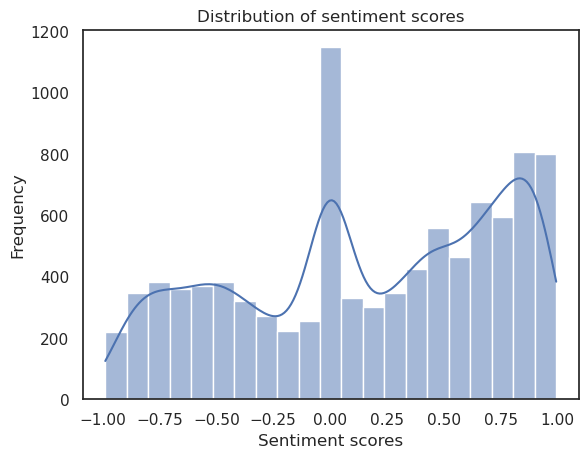

In [42]:
sentiment = SentimentIntensityAnalyzer()

compound_scores = []
for text in df['processed_tweet']:
    scores = sentiment.polarity_scores(text)
    compound_scores.append(scores['compound'])

sns.histplot(compound_scores, kde=True)
plt.title('Distribution of sentiment scores')
plt.ylabel('Frequency')
plt.xlabel('Sentiment scores')
plt.show()

In [45]:
def sentiment_analyzer(text):
    """
    Analyze the sentiment of a text string.

    Parameters
    ----------
    text : str
        The text string to analyze.

    Returns
    -------
    str
        The sentiment of the text string.
    """

    sentiment = SentimentIntensityAnalyzer()
    scores = sentiment.polarity_scores(text)

    if scores['compound'] > 0.4:
        return 'positive'
    
    else:
        return 'negative'


# Applying the function to the clean tweet
df['sentiments'] = df['processed_tweet'].apply(sentiment_analyzer)
df['sentiments'].value_counts()

negative    5495
positive    4045
Name: sentiments, dtype: int64

In [48]:
df['character_count'] = df['processed_tweet'].apply(len)
df['word_count'] = df['processed_tweet'].apply(lambda x: len(x.split()))
df.sort_values('character_count', ascending=False).head()

,tweet,time,year,month,day,day_name,time_of_tweet,hour_of_the_day,processed_tweet,sentiments,character_count,word_count
5226,ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï...,2023-06-03 11:38:13,2023,June,3,Saturday,11:38:13,11,ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½ï½...,negative,2554,3
563,"This loan started off quite well. Our rep, Don...",2023-06-05 16:36:36,2023,June,5,Monday,16:36:36,16,loan started quite well rep donna friendly qui...,positive,1394,201
2034,"I booked through this third-party site, paid e...",2023-06-02 09:19:45,2023,June,2,Friday,09:19:45,9,booked thirdparty site paid extra teller balco...,positive,1384,202
2940,"Liebes TripAdvisor-Mitglied, vielen Dank, dass...",2023-06-03 09:04:02,2023,June,3,Saturday,09:04:02,9,liebes tripadvisormitglied vielen dank das sie...,negative,1314,194
2936,"Liebes TripAdvisor-Mitglied, vielen Dank, dass...",2023-06-03 10:12:24,2023,June,3,Saturday,10:12:24,10,liebes tripadvisormitglied vielen dank das sie...,negative,1314,194


## Analyze the frequency of specific keywords or phrases in the review.

In [50]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['Bank of Nigeria', 'UBA', 'Zenith Bank', 'okay', 'best', 'worst', 
            'good', 'uncomfortable', 'service', 'Bank', 'excellent', 'Banking']

# Concatenate all the preprocessed feedback into a single string
processed_all_reviews = ' '.join(df['tweet'])

# Tokenize the text into individual words
tokens = processed_all_reviews.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")

Frequency of 'Bank of Nigeria': 0
Frequency of 'UBA': 20
Frequency of 'Zenith Bank': 0
Frequency of 'okay': 80
Frequency of 'best': 177
Frequency of 'worst': 220
Frequency of 'good': 994
Frequency of 'uncomfortable': 74
Frequency of 'service': 515
Frequency of 'Bank': 80
Frequency of 'excellent': 68
Frequency of 'Banking': 13


## Exploratory Data Analysis

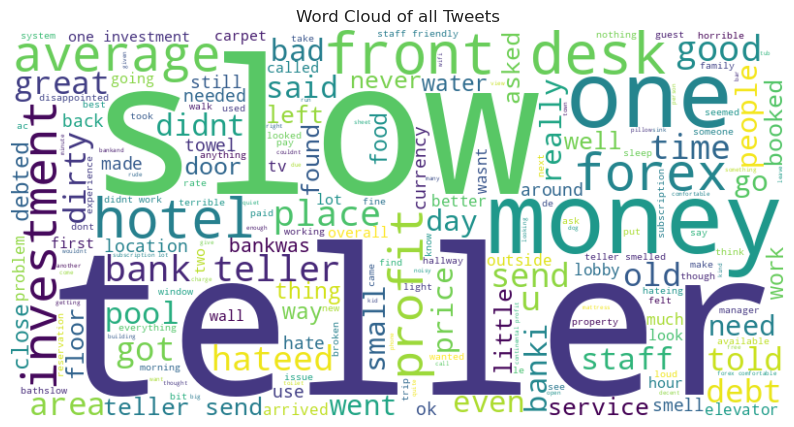

In [56]:
# Word cloud of all tweets

data = ' '.join(df['processed_tweet'])
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of all Tweets')
plt.show()

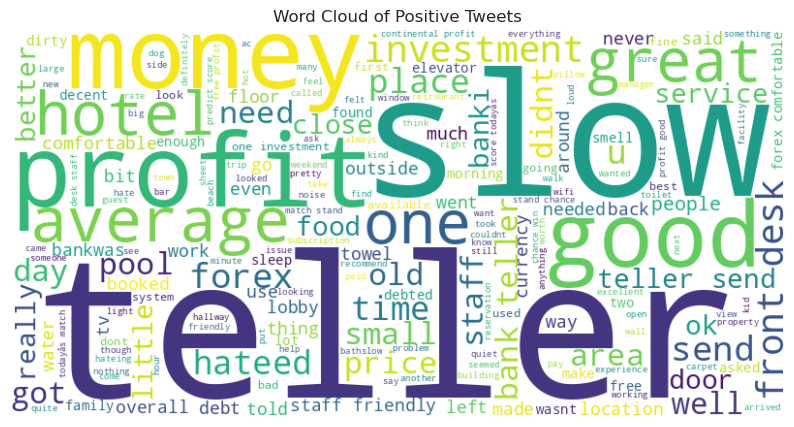

In [57]:
# Word cloud of positive tweets

data =' '.join(df[df['sentiments'] == 'positive']['processed_tweet'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Tweets')
plt.show()

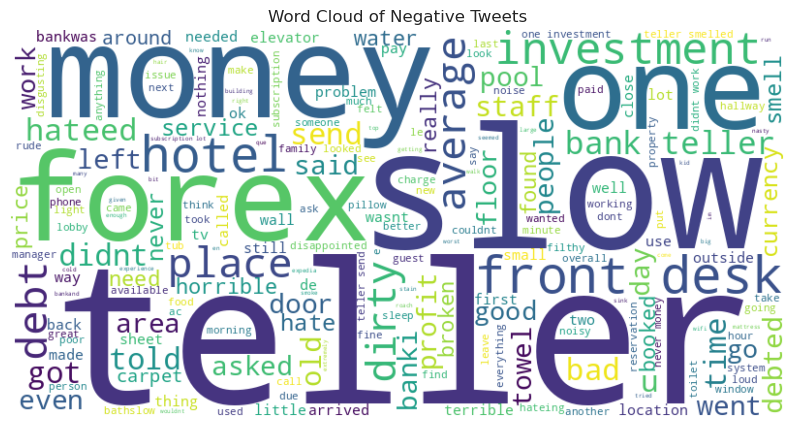

In [58]:
# Word cloud of negative tweets

data =' '.join(df[df['sentiments'] == 'negative']['processed_tweet'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Tweets')
plt.show()

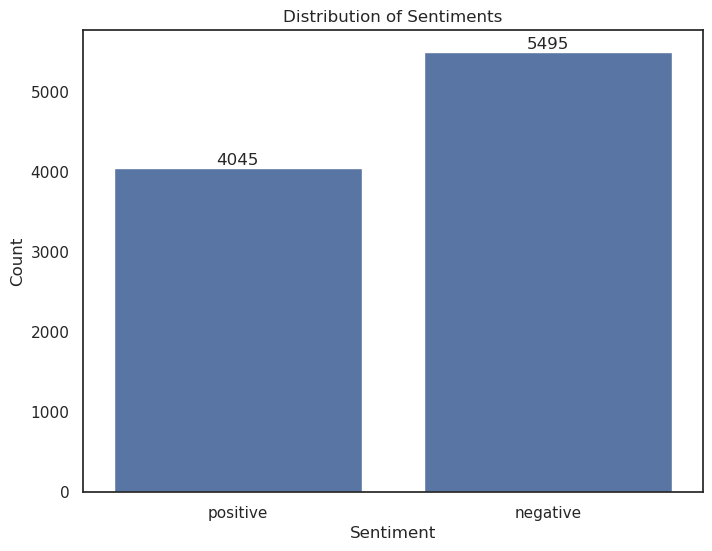

In [59]:
# Bar plot for Sentiment

plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
ax = sns.countplot(data=df, x='sentiments', color=color)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
plt.show()

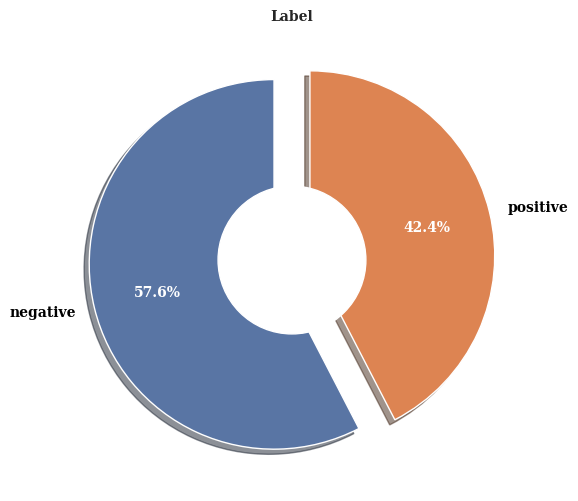

In [60]:
label_data = df['sentiments'].value_counts()
explode = (0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,
                               labels = label_data.index,
                               colors = ['#5975A4', '#DD8452'],
                               pctdistance = 0.65,
                               shadow = True,
                               startangle = 90,
                               explode = explode,
                               autopct = '%1.1f%%',
                               textprops={ 'fontsize': 10,
                                          'color': 'black',
                                          'weight': 'bold',
                                          'family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

Word Frequency Analysis

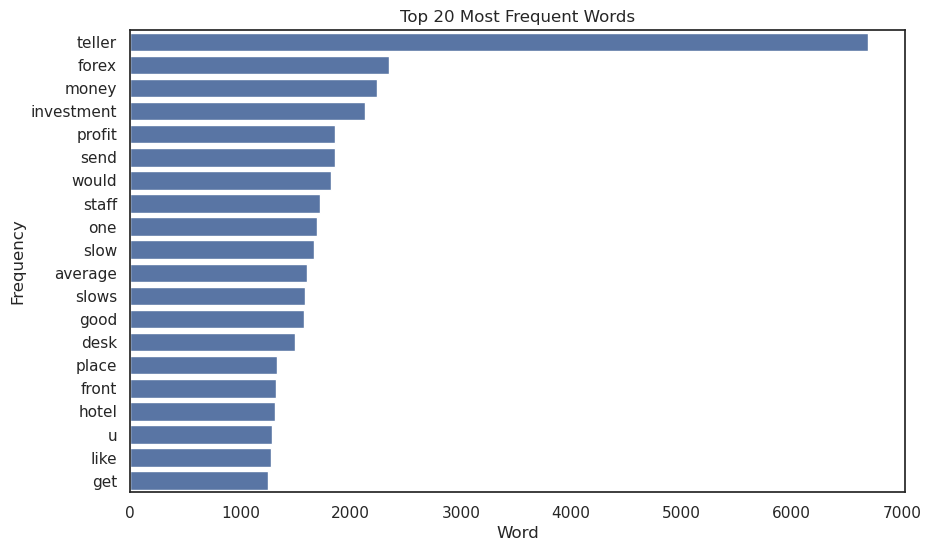

In [64]:
# Most common words in tweets

from collections import Counter
word_frequency = Counter(" ".join(df['processed_tweet']).split()).most_common(20)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.barplot(y=[word[0] for word in word_frequency], x=[word[1] for word in word_frequency], color=color)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.show()

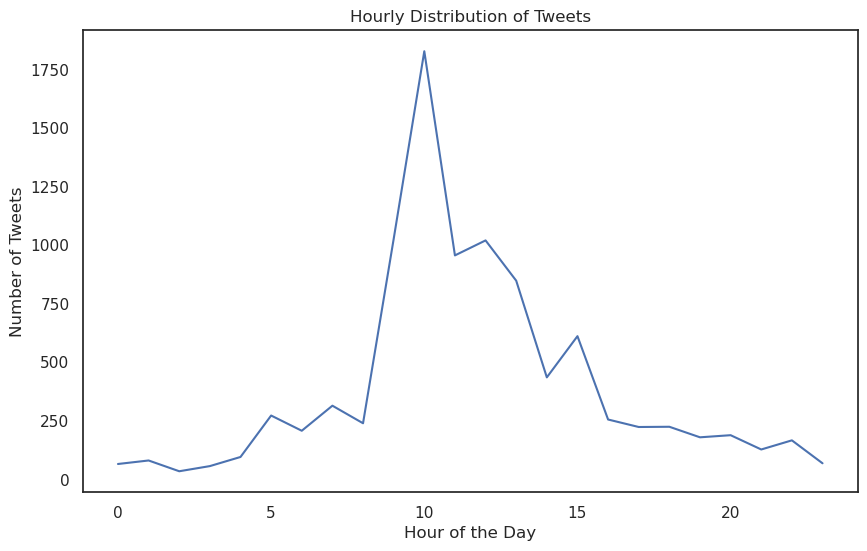

In [65]:
# distribution of tweets by hour of the day

plt.figure(figsize=(10, 6))
color=sns.color_palette()[0]
hourly_tweets = df.groupby('hour_of_the_day').size()
hourly_tweets.plot(kind='line', color=color)
plt.title('Hourly Distribution of Tweets')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()

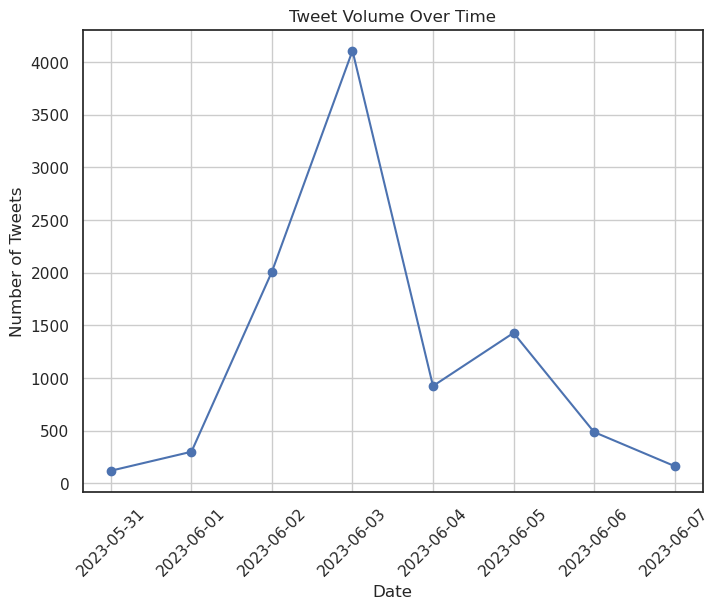

In [125]:
# number of tweets over time

tweet_counts_by_date = df.groupby(df['time'].dt.date).size()

# time series plot
plt.figure(figsize=(8, 6))
plt.plot(tweet_counts_by_date.index, tweet_counts_by_date.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Tweet Volume Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

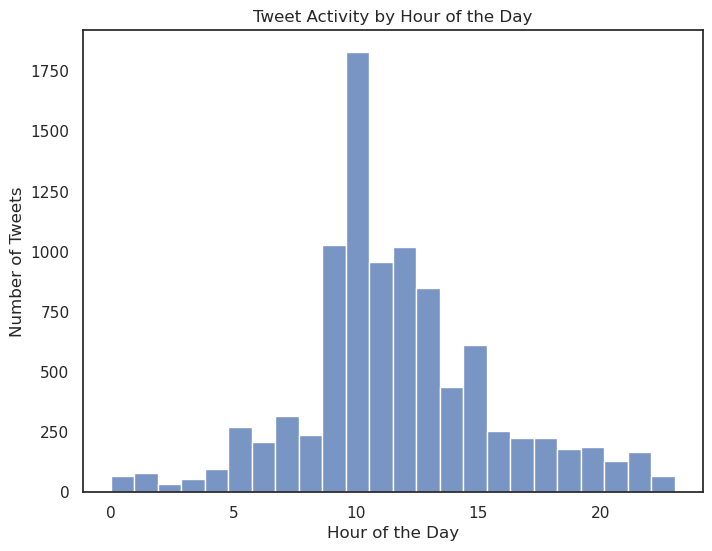

In [142]:
# Distribution of histogram of the hour of the day

plt.figure(figsize=(8, 6))
sns.histplot(df['hour_of_the_day'], bins=24, kde=False)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Tweets')
plt.title('Tweet Activity by Hour of the Day')
plt.show()

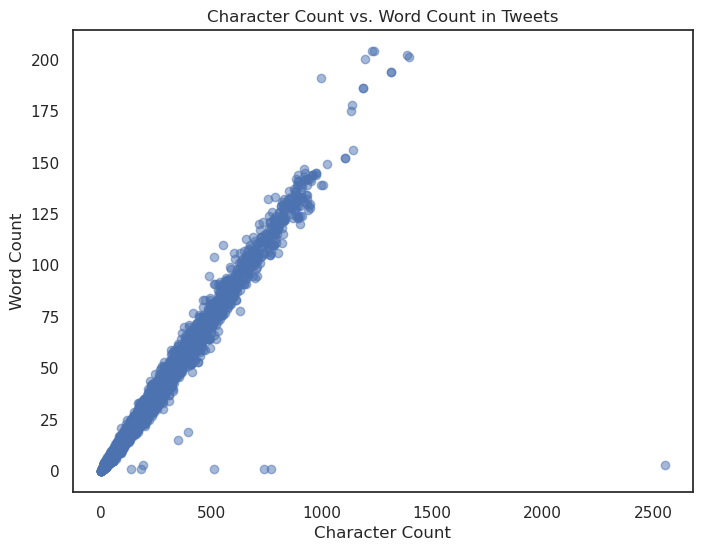

In [127]:
# scatter plot of character count vs. word count
plt.figure(figsize=(8, 6))
plt.scatter(df['character_count'], df['word_count'], alpha=0.5)
plt.xlabel('Character Count')
plt.ylabel('Word Count')
plt.title('Character Count vs. Word Count in Tweets')
plt.show()


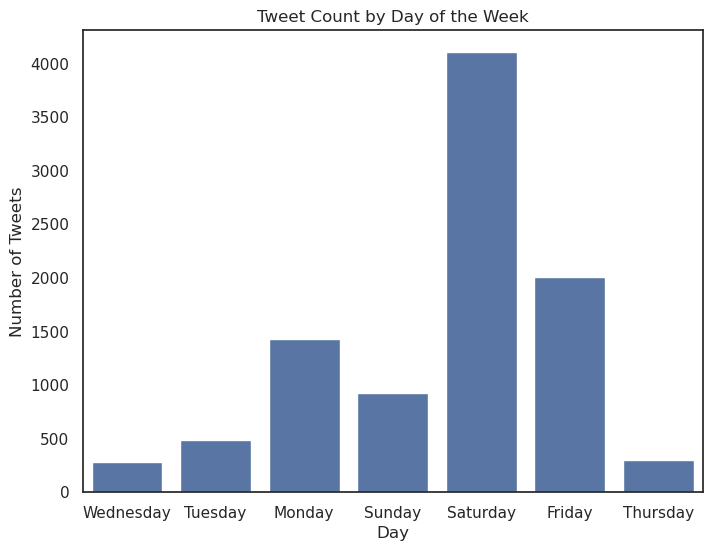

In [68]:
# Visualize the distribution of tweets across days of week

plt.figure(figsize=(8, 6))
color=sns.color_palette()[0]
order = df['day_name'].value_counts().index
sns.countplot(x='day_name', data=df, color=color, )
plt.title('Tweet Count by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.show()

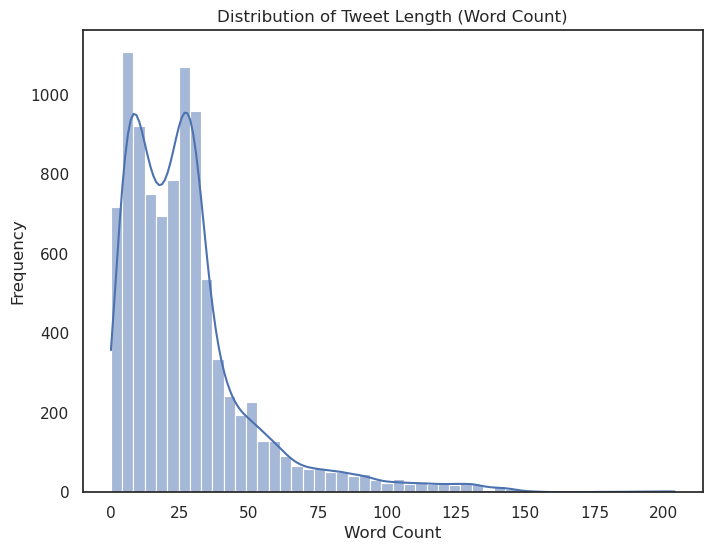

In [67]:
# Visualize the distribution of tweet lengths (word count)

plt.figure(figsize=(8, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Tweet Length (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

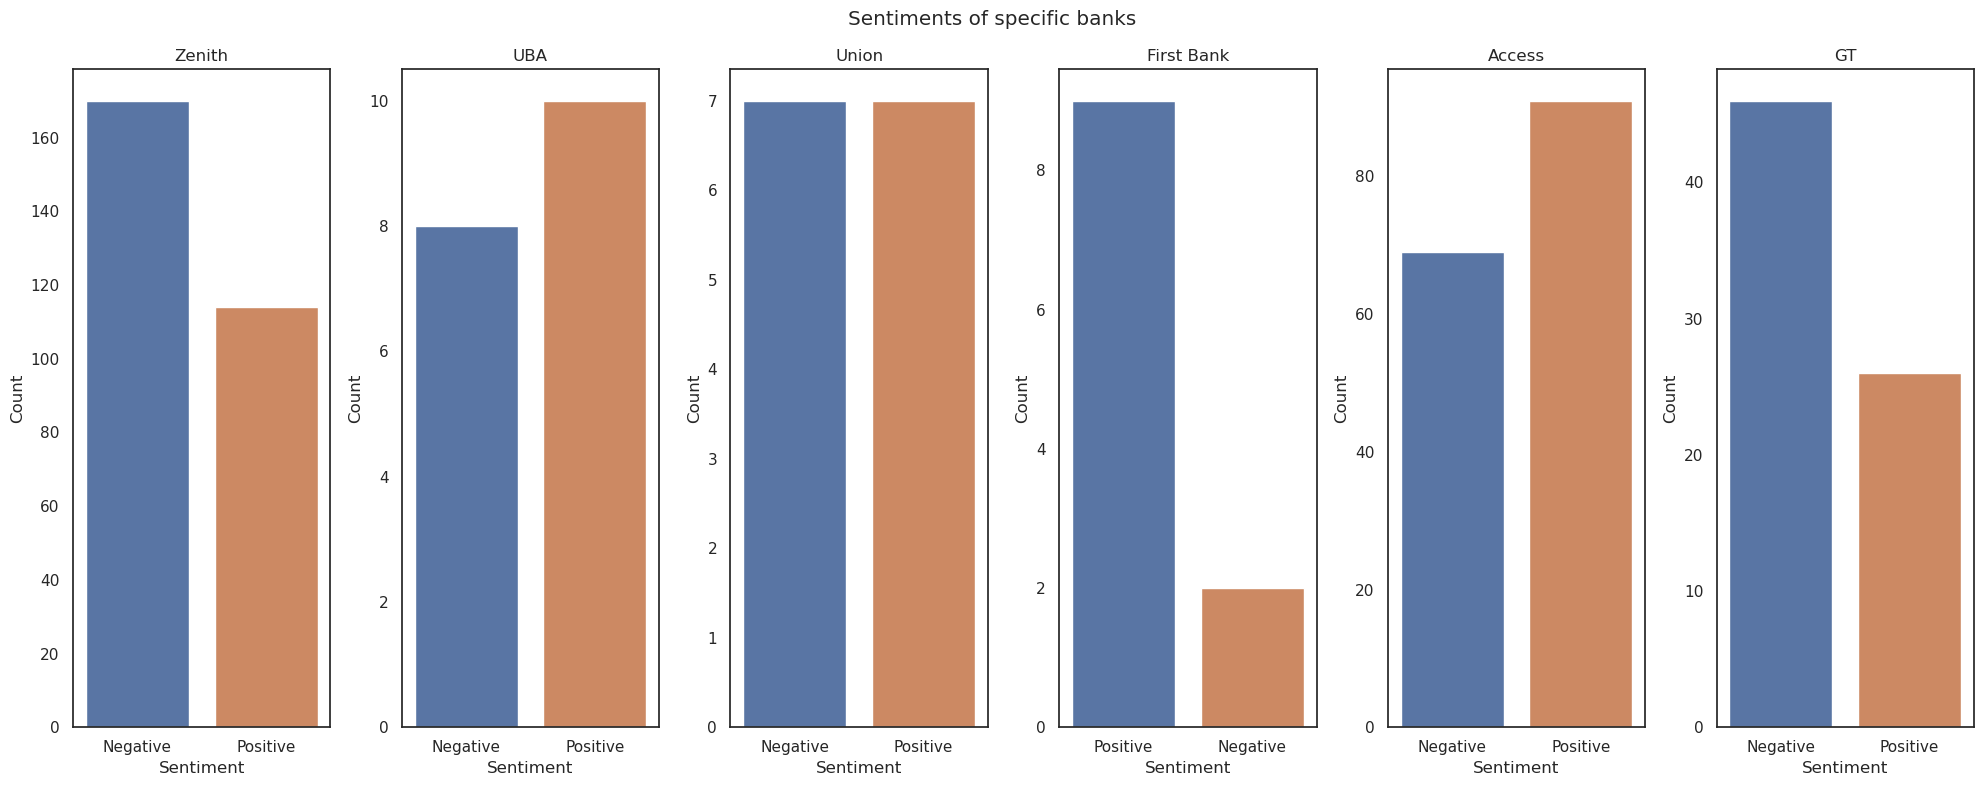

In [191]:
# Analyzing the sentiments of specific banks
banks_to_analyze = ['Zenith', 'UBA', 'Union', 'First Bank', 'Access', 'GT']
specific_banks_df = df[df['tweet'].str.contains('|'.join(banks_to_analyze), case=False)]

def get_sentiment_score(text):
    return sentiment.polarity_scores(text)['compound']

specific_banks_df['sentiment_score'] = specific_banks_df['tweet'].apply(get_sentiment_score)

# Classify tweets as positive or negative based on the sentiment polarity score
specific_banks_df['sentiment'] = specific_banks_df['sentiment_score'].apply(lambda score: 'Positive' if score > 0.4 else 'Negative')

plt.figure(figsize=(20, 8))
for i, bank in enumerate(banks_to_analyze):
    plt.subplot(1, len(banks_to_analyze), i+1)
    sns.countplot(x='sentiment', data=specific_banks_df[specific_banks_df['tweet'].str.contains(bank, case=False)])
    plt.suptitle('Sentiments of specific banks')
    plt.title(f'{bank}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Machine Learning Model

We build a ML model for predicting sentiment labels.

In [81]:
X = df['processed_tweet']
y = df['sentiments']

print(len(X), ',', len(y))

9540 , 9540


In [82]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('Encoded Target Labels:')
print(y_encoded, '\n')

# get mapping for each label
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mappings:')
print(le_name_mapping)

Encoded Target Labels:
[1 0 0 ... 1 1 0] 

Label Mappings:
{'negative': 0, 'positive': 1}


### XGBoost Classifier

In [83]:
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6678,) (6678,)
(2862,) (2862,)


In [179]:
# Using random train and test subsets

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
])

# Model
model = xgb.XGBClassifier(
    learning_rate=0.5,
    max_depth=6,
    n_estimators=150,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    reg_alpha=0.3,
    reg_lambda=0.1,
    gamma=0.5,
    
)


# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model),
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score: {} %'.format(accuracy*100))

Accuracy score: 86.37316561844864 %


In [180]:
# using cross validation techniques

# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
])

# Model
model = xgb.XGBClassifier(
    learning_rate=0.5,
    max_depth=6,
    n_estimators=150,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='logloss',
    reg_alpha=0.3,
    reg_lambda=0.1,
    gamma=0.5,
)


# Pipeline
pipeline_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model),
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_cv, X, y_encoded, cv=kf)
mean_cv_score = cv_scores.mean()
print('Cross-validation accuracy score: {} %'.format(mean_cv_score*100))

Cross-validation accuracy score: 85.74423480083858 %


The performance of the model could still be optimized by performing hyper-parameter tuning.

In [185]:
# other evaluation metrics

print('Recall Score: {:.5f} %'.format(recall_score(y_test, y_pred)*100))
print('Precision Score: {:.5f} %'.format(precision_score(y_test, y_pred)*100))
print('ROC_AUC Score: {:.5f} %'.format(roc_auc_score(y_test, y_pred)*100))

Recall Score: 83.09975 %
Precision Score: 84.49288 %
ROC_AUC Score: 85.94042 %


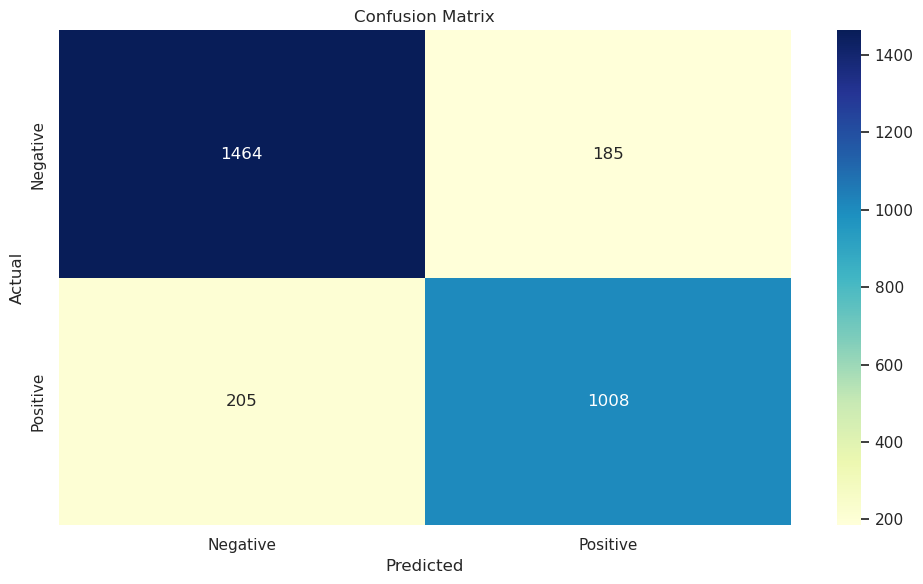

In [186]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Support Vector Machine (SVM) Classifier

In [96]:
# Preprocessor
preprocessor = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
])

# Model (SVM Classifier)
svm_model = SVC(
    C=1.0,
    kernel='linear',
    degree=3,
    gamma='auto',
    coef0= 0.0,
    probability=True,
    class_weight='balanced',
)

# Pipeline
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svm_model),
])

pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Accuracy score: {} %'.format(accuracy_svm*100))


Accuracy score: 86.617749825297 %


In [97]:
# other evaluation metrics

print('Recall Score: {:.5f} %'.format(recall_score(y_test, y_pred_svm)*100))
print('Precision Score: {:.5f} %'.format(precision_score(y_test, y_pred_svm)*100))
print('ROC_AUC Score: {:.5f} %'.format(roc_auc_score(y_test, y_pred_svm)*100))

Recall Score: 84.58368 %
Precision Score: 83.96072 %
ROC_AUC Score: 86.34884 %


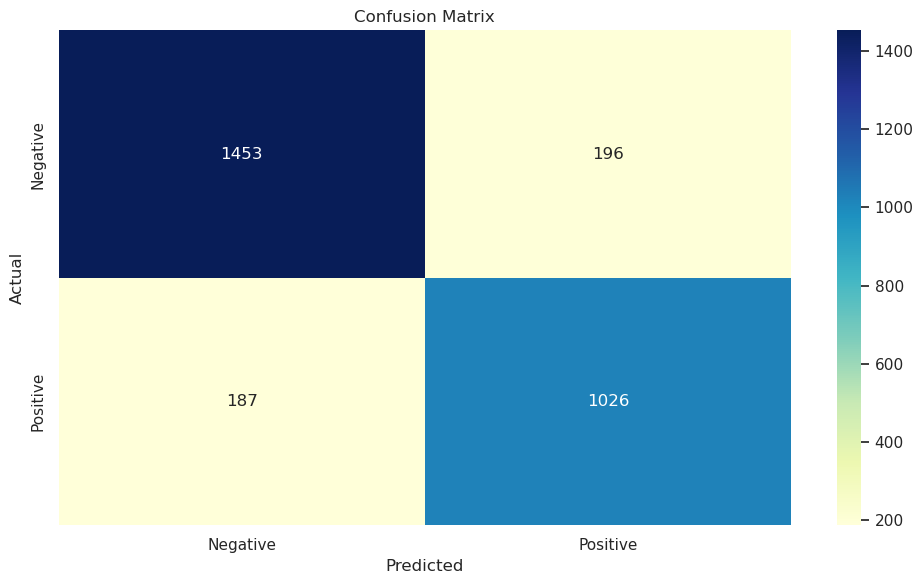

In [102]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Comparing Accuracy Scores of the Models

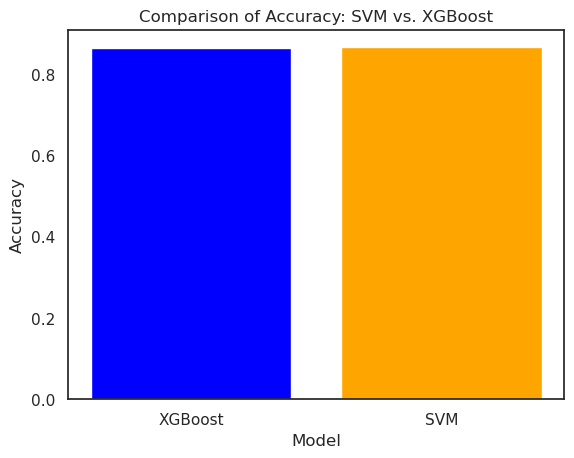

In [187]:
plt.bar(['XGBoost', 'SVM'], [accuracy, accuracy_svm], color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy: SVM vs. XGBoost')

plt.show()


## **Making Random predictions**

### With the XGBoost Model

In [108]:
print('Label Mappings:')
print(le_name_mapping)

pipeline.fit(X, y_encoded)
sentiment_categories = {0: 'negative', 1: 'positive'}
print(sentiment_categories)

Label Mappings:
{'negative': 0, 'positive': 1}
{0: 'negative', 1: 'positive'}


In [199]:
new_examples = [
    "@ZenithBank, what's up with your ATMs? 🏧🤷‍♀️ Half of them are out of cash, and the rest are always broken. Do you guys even maintain them?",
    "I swear @gtbank has the worst online banking platform! 😠📱 It's slow, clunky, and full of bugs. Time to find a better bank.",
    "How hard is it for @UBA to answer a simple email? 📧🤦‍♂️ Been waiting for days, and still no response. Way to treat your customers!",
    "Dear @FidelityBankPLC, your interest rates are a joke! 💤💤 Might as well keep my money under the mattress.",
    "Just had the best experience at First Bank 🎉 Love their friendly staff and quick service! 💯",
    "Ugh, seriously @ZenithBank? 🙄 Been waiting in line for ages, and no one seems to care. Time to switch banks, I guess. 😒",
    "Shoutout to @FidelityBankPLC 🙌 Just got my savings interest, and it's way better than I expected! 💰",
    "Naija banks, step up your game! 🚀 We need more innovative products and better customer support!",
    "Make una no go vex perosn with this early morning poor service all this banks ooo!",
    "Zenith bank, abeg make una allow this money drop or revise it. Abeg, the money is in need for urgent medical attention",
    "Awon Bank yi ti ya werey sha",
    "Why am I receiving pos debit for February and March over a declined transaction?? Is the bank robbing me @gtbank_help",
    "Okay, First Bank na better bank"
]

In [200]:
predicted_sentiments = pipeline.predict(preprocess_text(example) for example in new_examples)
predicted_sentiment_labels = [sentiment_categories[sentiment] for sentiment in predicted_sentiments]

print("Predicted Sentiments:", predicted_sentiment_labels)

Predicted Sentiments: ['negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive']


### With the SVM Model

In [201]:
predicted_sentiments = pipeline_svm.predict(preprocess_text(example) for example in new_examples)
predicted_sentiment_labels = [sentiment_categories[sentiment] for sentiment in predicted_sentiments]

print("Predicted Sentiments:", predicted_sentiment_labels)

Predicted Sentiments: ['negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive']


**Export the dataset to evaluate it using BERT and KerasNLP.**

In [107]:
df.to_csv('tweets2.csv', index=False)